In [1]:
from groundino_samnet.model import GSamnet, load_models
from torchinfo import summary
import torch
from DataSets.getdata import thermal_feet_dataset, ToBoolTensor, PermuteTensor
from torchvision.transforms import transforms
from Metrics.Metrics import Metrics
import matplotlib.pyplot as plt
from groundino_samnet.visuals import plot_grid_sam, show_result

c:\Users\WilhelmB\miniconda3\envs\DiagAI2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_mask = transforms.Compose([
    ToBoolTensor(),
    PermuteTensor((1,2,0)) # (WxHxC)
])
transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.uint8),
    PermuteTensor((1,2,0)) #(WxHxC)
])
dataset = thermal_feet_dataset(dataset="mtf", credentials_path="C:\\Users\\WilhelmB\\Desktop\\kaggle.json")
datasetfull = dataset.generate_dataset(torch_dataset=True,
                                       batch_size=190,
                                       shuffle=True,
                                       merge_image=True,
                                       transform_img=transform_img,
                                       transform_mask=transform_mask
                                       )

DATASET = dataset.generate_dataset(torch_dataset=False,
                                   merge_image=True,
                                   transform_mask=transform_mask,
                                   transform_img=transform_img)

Dataset URL: https://www.kaggle.com/datasets/lucasiturriago/mamitas-thermal-feet
Notice: Remember to use the <cleanup> function when you stop using the dataset to delete the temporary data (images and masks).


In [12]:
dataset.cleanup()

In [3]:
sam = load_models("sam2_l")
dino = load_models("dino")

sam_args = {
    "model": sam,
    "points": True,
    "torch": True
}

dino_args = {
"model": dino,
}

model = GSamnet(dino_args=dino_args,sam_args=sam_args).to(sam.device)

final text_encoder_type: bert-base-uncased


# Predict for a single image

In [33]:
image, mask,ids = DATASET.__getitem__(0)

In [4]:
model.eval()
model.dummy_input() #Recommended

Notice: Warm-up inference completed.


In [35]:
with torch.no_grad():
    result = model([image])

In [36]:
Metrics().calculate_metrics(y_pred=result,y_true=mask)

{'jaccard': 0.9808701276779175,
 'dice': 0.9903426766395569,
 'sensitivity': 0.9920978546142578,
 'specificity': 0.9948030114173889}

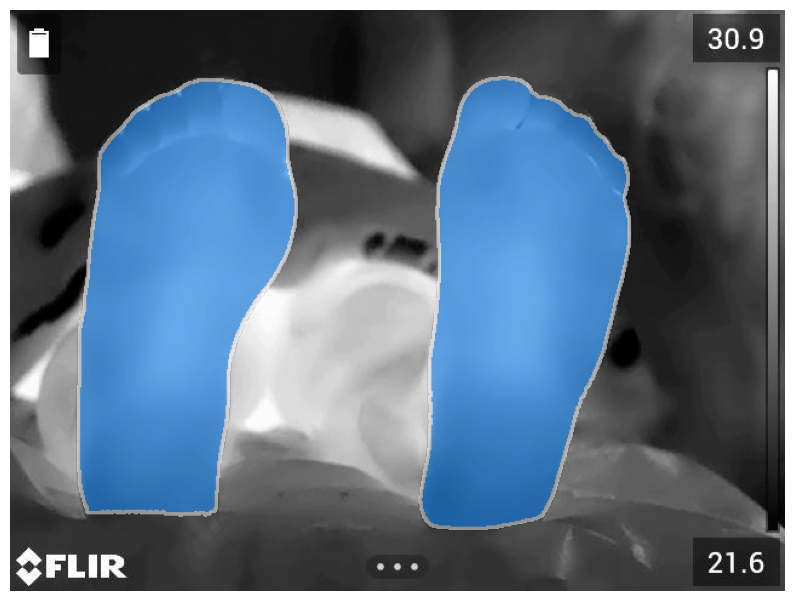

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [39]:
show_result(image=image,mask=result)

# Predict for a batch of images

In [5]:
model.eval()
with torch.no_grad():
    for image,mask,ids in datasetfull:
        result = model(image)
        

In [41]:
data = {"Images": image,
        "Original": mask,
        "Prediction": result,
        "ids": ids}

In [42]:
metricas, promedio = Metrics.calculate_average_mask_metrics(data)

jaccard Promedio = 0.9086316175600315
dice Promedio = 0.9442120853890764
sensitivity Promedio = 0.9366360219552162
specificity Promedio = 0.9882714827644065


In [43]:
promedio

,jaccard,dice,sensitivity,specificity
0,0.908632,0.944212,0.936636,0.988271


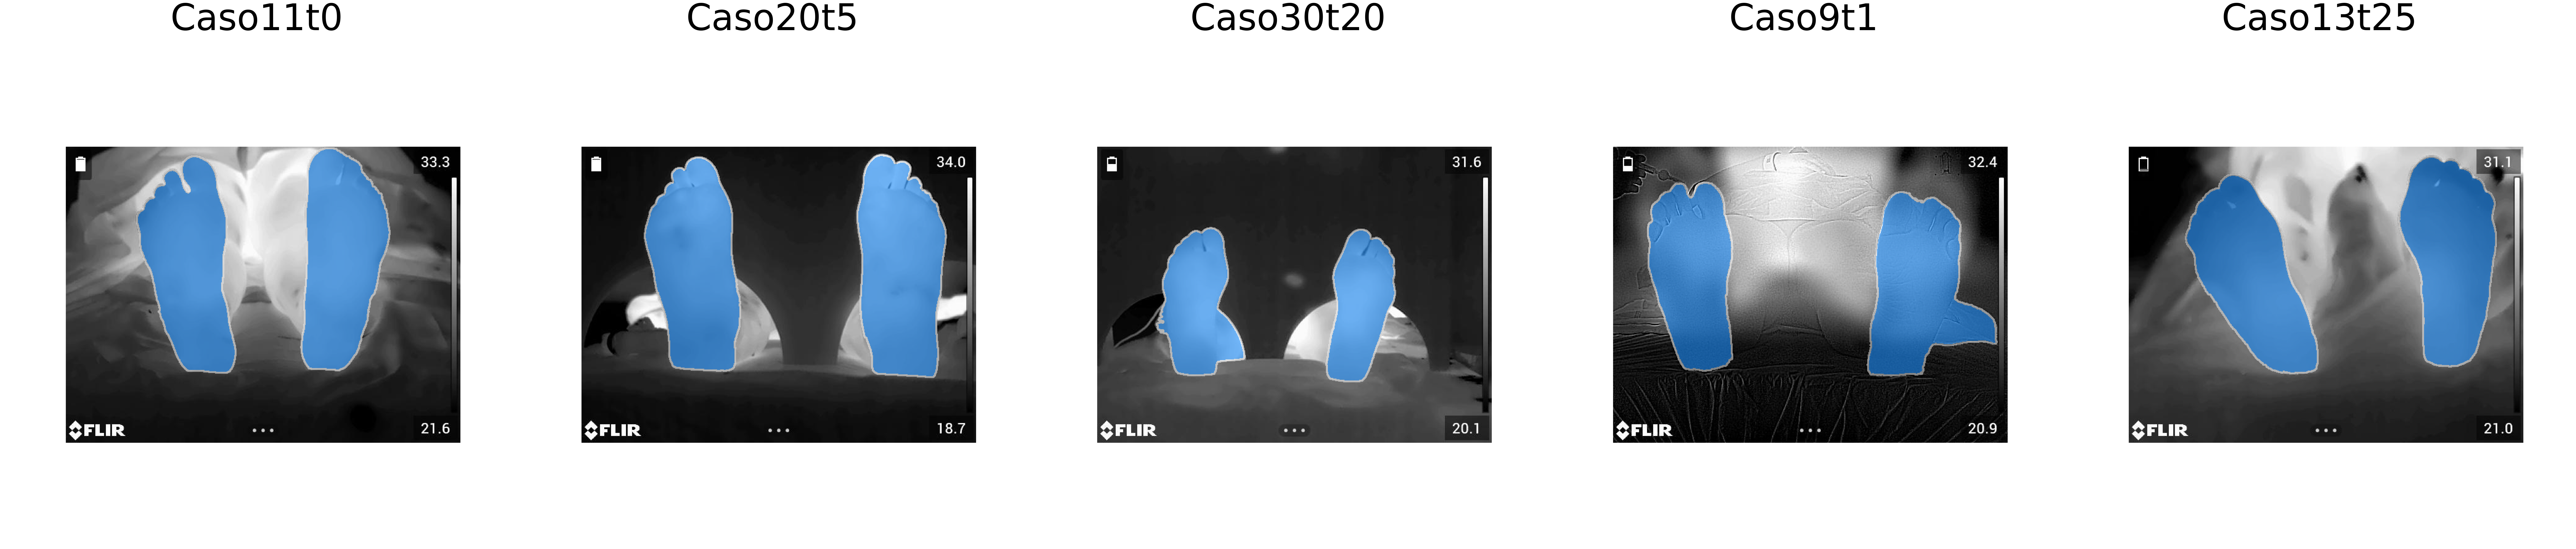

In [12]:
plot_grid_sam(images=image,idss=ids,masks=result,image_max=5)

# Calculate FPS

In [23]:
fps = Metrics().calculate_fps(model=model,images=datasetfull)

188
Average Time per Image: 0.4646 seconds
FPS: 2.2
